In [2]:
###Figure 1 Panel D
#m768 (Ahl/ahl), m771 (ahl/ahl), m722 (F1) are examples
import sys
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##import 
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
import utils
import plotting
import config

save_path = config.save_path
data_path = config.data_path

mice = utils.groupData(dir=data_path, analysis_file_name = "wfstack_3.pkl").mice
if not save_path.exists():
    save_path.mkdir()

In [4]:
#do an analysis just for figure and load mean_dfof
force = False ### will force reanalysis of example mice
mouseList = ["m768","m771", "m722"]
mean_dfof_path = "analysis/mean_dfof.npy"

mean_dfofs = []
for mouse in mouseList:
    path1 = utils.findUnanalyzedStacks(data_path,pattern="**/"+ mouse + "/Widefield/[0-9]*",foldername="all")
    data_save_path = path1[0] / mean_dfof_path
    print(data_save_path)
    if not data_save_path.exists() or force: ###this will run enough of the analysis to get us the mean_dfof signal for each freq and sound level
        save_path.parents[0].mkdir(exist_ok=True)
        temp = utils.widefieldStack(path1[0])
        temp.unmix()
        temp.removeAnamolies()

        save_dir = "fig"
        temp.generateMap(frameToTake=45, save_dir=save_dir)
        temp.generateFRA(startFrame=40, endFrame=50,save_dir=save_dir)
        temp.calculate_percentiles(percentile=99)
        temp.calculate_area(tresholdStd=1.5)
        temp.dFoF(temp.unmixed)
        mean_dfof = np.nanmean(temp.unmixed_dfof,axis=-1)
        np.save(data_save_path, mean_dfof)
        mean_dfofs.append(mean_dfof)

        temp.dumpRawData()
        import pickle
        file = open(temp.dir / "wfstack_fig.pkl", 'wb')
        pickle.dump(temp, file)
        file.close()
    else: ### load mean_dfof
        mean_dfofs.append(np.load(data_save_path, allow_pickle=True))

ex_mice = pd.DataFrame({'Mouse':mouseList})
ex_mice = ex_mice.merge(mice[['Mouse','Genotype']], on='Mouse')
ex_mice['gain'] = [[1.5, 1, 2],[1.5, 1, 2],[1, 1, 1.1]]
ex_mice['panel'] = ['Fig1_G_','Fig1_D_','SF1_A_']


**/m768/Widefield/[0-9]* all
c:\Users\travisb\Dropbox (Personal)\Cdh23\Data\m768\Widefield\220614\analysis\mean_dfof.npy
**/m771/Widefield/[0-9]* all
c:\Users\travisb\Dropbox (Personal)\Cdh23\Data\m771\Widefield\220614\analysis\mean_dfof.npy
**/m722/Widefield/[0-9]* all
c:\Users\travisb\Dropbox (Personal)\Cdh23\Data\m722\Widefield\220405\analysis\mean_dfof.npy


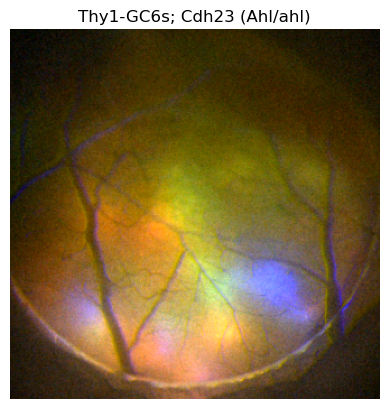

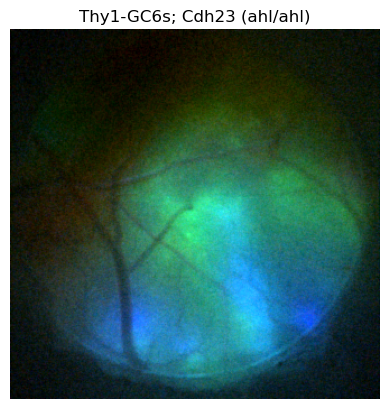

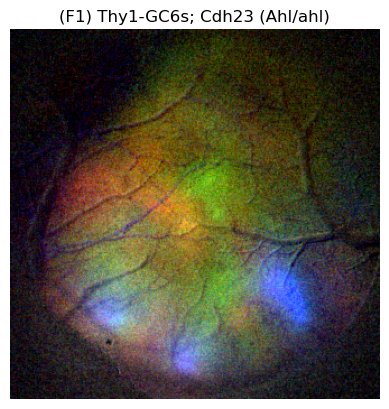

In [14]:
for i, mouse in ex_mice.iterrows():
    img = plotting.getMap(mean_dfofs[i], gain=mouse['gain'])
    fig, ax = plt.subplots()
    ax.imshow(img,vmin=0, vmax=1)
    ax.set_title(mouse['Genotype'])
    ax.axis('off')

    plt.savefig(save_path / ("Fig1_" + mouse['panel'] + str(mouse['Genotype']).replace("/", "") +"tonotopic_map.svg"))


**/m768/Widefield/[0-9]* all
10
**/m771/Widefield/[0-9]* all
10
**/m722/Widefield/[0-9]* all
10


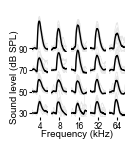

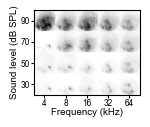

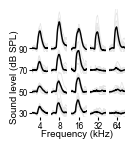

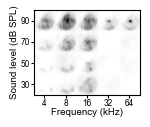

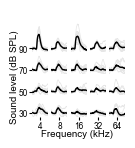

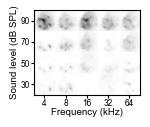

In [16]:
##individual panels

import numpy as np
import matplotlib.pyplot as plt
import plotting
mouseList = ["m768","m771", "m722"]
panels = ["Fig1_G_", "Fig1_D_", "SF1A_"]
vmax = [0.13, 0.13, 0.07]
ind_data = pd.DataFrame({'Mouse':mouseList, 'panel':panels, 'vmax':vmax})


plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
ylabels = [90,70,50,30]
xlabels = [4,8,16,32,64]
tickfontsize = 6
labelfontsize = 7

for i, mouse in ind_data.iterrows():
    path1 = utils.findUnanalyzedStacks(data_path,pattern="**/"+ mouse.Mouse + "/Widefield/[0-9]*",foldername="all")
    temp = np.load(path1[0] / "wfstack_fig.pkl", allow_pickle=True)

    fig, axs = plotting.plotFRAtraces(temp.percentileResponse, ymin = -0.02, ymax = 0.2)
    fig.set_figheight(1.4)
    fig.set_figwidth(1.2)
    fig.supxlabel("Frequency (kHz)", fontsize = labelfontsize , y = -0.04)
    fig.supylabel("Sound level (dB SPL)", fontsize = labelfontsize , x=-0.06, y = 0.4)
    plt.savefig(save_path / (mouse['panel'] + mouse['Mouse'] + "_FRA_99perc.svg"), dpi=900)

    plt.figure(figsize=(1.6,1.5), layout="tight")
    plt.imshow(temp.FRA, cmap='Greys',vmin=0,vmax=mouse['vmax'])
    plt.tick_params(axis='both',length=2, pad=1)       
    plt.xticks(np.arange(0,5)*330+330/2, xlabels, fontsize=tickfontsize)
    plt.xlabel("Frequency (kHz)", fontsize=labelfontsize, labelpad=0)
    plt.ylabel("Sound level (dB SPL)", fontsize=labelfontsize, labelpad=1)
    plt.yticks(np.arange(0,4)*330+330/2, ylabels, fontsize=tickfontsize)
    plt.savefig(save_path / (mouse['panel'] + mouse['Mouse']  + "_FRA_2mo.svg"),dpi=900)
    
   

11
10
7


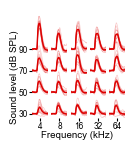

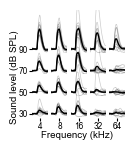

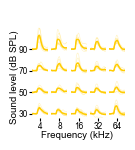

In [8]:
##group data
import utils
import plotting
from pathlib import Path
import pickle 

mice = utils.groupData(dir=data_path, analysis_file_name = "wfstack_3.pkl").mice

color_dict = config.color_dict

genos = mice.Genotype.unique()
escapes = ["\\"]
data = []
for geno in genos:
    means = []
    for i, mouse in mice[mice.Genotype==geno].iterrows():
        means.append(np.nanmean(mouse.data.percentileResponse,axis=3)[:,:,:,np.newaxis])
    data.append((geno, means))

panels = ['Fig1_H_','Fig1_E_','SF1_B_']
for i, (geno, response) in enumerate(data):
    fig, axs = plotting.plotFRAtraces(np.concatenate(response, axis=3), ymin = -0.02, ymax=0.20, mean_color=color_dict[geno], mean_to_ind_alpha=0.2)
    fig.set_figheight(1.4)
    fig.set_figwidth(1.2)
    fig.supxlabel("Frequency (kHz)", fontsize = 7, y = -0.05)
    fig.supylabel("Sound level (dB SPL)", fontsize = 7, x=-0.06, y = 0.4)

    # fig.set_constrained_layout(constrained=True)
    plt.savefig(save_path / (panels[i] + str(geno).replace("/", "") +"neq"+str(len(response)) + "_new_group_response.svg"))
